# 对比不同因子IC
1. 读取本地数据
2. 数据预处理
3. 计算月度IC
4. 对比不同因子的IC值
5. IC的时间序列
6. 计算各个因子的IR

## 1_读取本地数据

In [1]:
from jaqs.data.dataapi import DataApi
from jaqs.data import DataView
import numpy as np
from datetime import datetime
import pandas as pd
import warnings
import alphalens

warnings.filterwarnings("ignore")
dataview_folder = '../../JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

C:\ProgramData\Anaconda3\envs\qtc\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


## 2_数据预处理

In [2]:
def change_columns_index(signal):
    new_names = {}
    for c in signal.columns:
        if c.endswith('SZ'):
            new_names[c] = c.replace('SZ', 'XSHE')
        elif c.endswith('SH'):
            new_names[c] = c.replace('SH', 'XSHG')
    signal = signal.rename_axis(new_names, axis=1)
    signal.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , signal.index))
    return signal

In [3]:
all_factor = ['pb', 'roe', 'roa', 'price_div_dps', 'ps_ttm', 'pe_ttm']

In [4]:
origin_factors = {f: change_columns_index(dv.get_ts(f)) for f in all_factor}

In [5]:
from jaqs.research.signaldigger import process

#去极值,z_score标准化,加干扰值
PN_disturbed = pd.Panel({name: process.get_disturbed_factor(process.standardize(process.winsorize(frame)))\
                         for name, frame in origin_factors.items()})

In [6]:
print(PN_disturbed)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 1453 (major_axis) x 539 (minor_axis)
Items axis: pb to roe
Major_axis axis: 2012-01-04 00:00:00 to 2017-12-22 00:00:00
Minor_axis axis: 000001.XSHE to 603993.XSHG


In [7]:
prices = change_columns_index(dv.get_ts('close_adj'))

## 3_计算月度IC
alphalens.performance.mean_information_coefficient()

In [8]:
def cal_monthly_ic(factor_df):
    factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_df.stack(), prices, quantiles=5)
    return alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
monthly_ic = {key: cal_monthly_ic(value) for key, value in PN_disturbed.iteritems()}

Dropped 0.7% entries from factor data (0.7% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 0.7% entries from factor data (0.7% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 0.7% entries from factor data (0.7% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 0.7% entries from factor data (0.7% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 3.5% entries from factor data (3.5% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 3.5% entries from factor data (3.5% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [9]:
print(list(monthly_ic.values())[0].tail())

                  1         5         10
date                                    
2017-08-31 -0.001244  0.062893  0.089162
2017-09-30  0.032251  0.094159  0.137523
2017-10-31  0.041370  0.111515  0.134461
2017-11-30 -0.040656 -0.086993 -0.116240
2017-12-31  0.094788  0.264368  0.234474


In [10]:
monthly_ic_mean = pd.DataFrame(
    list(map(lambda frame: frame.mean(), monthly_ic.values())),
    monthly_ic.keys()
)

monthly_ic_std = pd.DataFrame(
    list(map(lambda frame: frame.std(), monthly_ic.values())),
    monthly_ic.keys()
)

In [11]:
print(monthly_ic_mean)
print (monthly_ic_std)

                     1         5         10
pb            -0.013325 -0.010548 -0.014964
pe_ttm        -0.008826 -0.010847 -0.015992
price_div_dps -0.004182 -0.003566 -0.006555
ps_ttm        -0.004566 -0.002511 -0.004184
roa            0.008080  0.018152  0.023131
roe            0.006232  0.013954  0.020101
                     1         5         10
pb             0.055424  0.123564  0.159495
pe_ttm         0.037940  0.083801  0.112219
price_div_dps  0.029029  0.064609  0.086106
ps_ttm         0.044331  0.097754  0.127836
roa            0.034686  0.080591  0.105436
roe            0.030432  0.070704  0.097226


## 4_对比不同因子的IC值

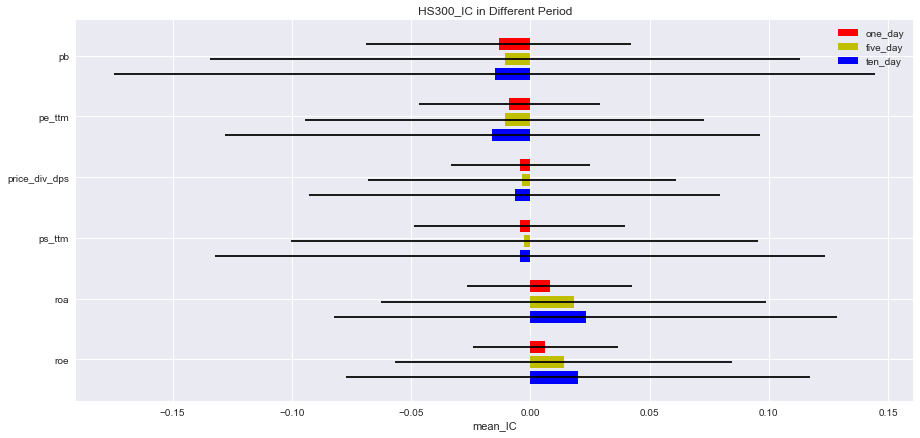

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15,7))

N=6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

# Example data
ind_name = tuple(monthly_ic_mean.index)
y_pos = np.arange(len(ind))

one_mean = monthly_ic_mean.iloc[:,0]
one_std = monthly_ic_std.iloc[:,0]
five_mean = monthly_ic_mean.iloc[:,1]
five_std = monthly_ic_std.iloc[:,1]
ten_mean = monthly_ic_mean.iloc[:,2]
ten_std = monthly_ic_std.iloc[:,2]


ax.barh(ind - width, one_mean, align='edge',height=0.2, xerr=one_std, label='one_day', color='r')
ax.barh(ind - 0.05, five_mean, align='edge',height=0.2,xerr=five_std, label='five_day', color='y')
ax.barh(ind + width, ten_mean, align='center',height=0.2,xerr=ten_std, label='ten_day', color='b')

ax.set_yticks(y_pos)
ax.set_yticklabels(ind_name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('mean_IC')
ax.set_title('HS300_IC in Different Period')
plt.legend()
plt.show()

## 5_IC的时间序列

In [13]:
PN_IC = pd.Panel(monthly_ic)

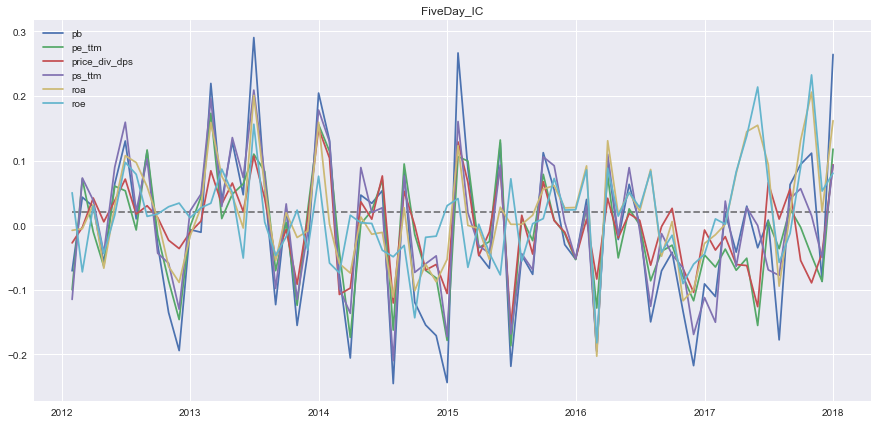

In [14]:
fig = plt.figure(figsize=(15,7))
plt.plot(PN_IC.minor_xs(5))
plt.hlines(0.02,PN_IC.minor_xs(5).index[0],PN_IC.minor_xs(5).index[-1] , linestyles='dashed', alpha=0.5)
plt.legend(PN_IC.minor_xs(5).columns)
plt.title('FiveDay_IC')
plt.show()

## 6_计算各个因子的IR

In [15]:
def IR(df):
    return df.mean()/df.std()
print ('OneDay_IR:\n', IR(PN_IC.minor_xs(1)))
print ('FiveDay_IR:\n', IR(PN_IC.minor_xs(5)))
print ('TenDay_IR:\n', IR(PN_IC.minor_xs(10)))

OneDay_IR:
 pb              -0.240429
pe_ttm          -0.232646
price_div_dps   -0.144064
ps_ttm          -0.102996
roa              0.232943
roe              0.204774
dtype: float64
FiveDay_IR:
 pb              -0.085362
pe_ttm          -0.129432
price_div_dps   -0.055198
ps_ttm          -0.025685
roa              0.225234
roe              0.197352
dtype: float64
TenDay_IR:
 pb              -0.093821
pe_ttm          -0.142511
price_div_dps   -0.076122
ps_ttm          -0.032729
roa              0.219386
roe              0.206749
dtype: float64
